# Receipt_Count Prediciton Model - Dario Placencio

In [134]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [99]:
# Read the data
df = pd.read_csv('data_daily.csv')

In [100]:
# Convert the data type of Date to datetime
df['# Date'] = pd.to_datetime(df['# Date'])

In [101]:
# Change name of column
df.rename(columns={'# Date': 'Date'}, inplace=True)

In [102]:
# Set Date as index
df.set_index('Date', inplace=True)

In [103]:
# Preview the data
df.head()

,Receipt_Count
Date,
2021-01-01,7564766
2021-01-02,7455524
2021-01-03,7095414
2021-01-04,7666163
2021-01-05,7771289


In [104]:
print(df.index)

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=365, freq=None)


In [105]:
# Describe type
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2021-01-01 to 2021-12-31
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Receipt_Count  365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


# Autoregressive Integrated Moving Average (ARIMA)

In [106]:
def fit_arima(history, p, d, q):
    # Parameters are hardcoded for simplicity, a robust model would estimate these
    ar_params = np.array([0.5])
    ma_params = np.array([0.5])
    residuals = np.zeros(q)
    return ar_params, ma_params, residuals

def forecast_arima(history, ar_params, ma_params, residuals, p, d, q):
    diff = np.diff(history, n=d)
    ar_component = np.dot(ar_params, diff[-p:][::-1])
    ma_component = np.dot(ma_params, residuals)
    forecast = history[-1] + ar_component + ma_component
    return forecast

def expanding_window_arima(train, test_length):
    forecasts = []
    history = list(train)
    p, d, q = 1, 1, 1
    
    for i in range(test_length):
        ar_params, ma_params, residuals = fit_arima(history, p, d, q)
        yhat = forecast_arima(history, ar_params, ma_params, residuals, p, d, q)
        forecasts.append(yhat)
        history.append(train.iloc[i])
    
    return forecasts

In [107]:
test_length = 65  # Test of 22% of the data

In [108]:
# Training
train = df['Receipt_Count'][:-test_length]

# Testing
test = df['Receipt_Count'][-test_length:]

In [109]:
# Expanding Window ARIMA
arima_forecasts = expanding_window_arima(train, test_length)

# Seasonal Decomposition of Time Series (STL)

STL itself is not a forecasting model. It's a decomposition method. On this case used for the residual component with an ARIMA model for forecasting

In [118]:
def fit_STL(history, p, d, q):
    
    trend = np.array([0.5])
    seasonal = np.array([0.5])
    residuals = np.zeros(q)
    return trend, seasonal, residuals

def forecast_STL(history, trend, seasonal, residuals, p, d, q):
    diff = np.diff(history, n=d)
    trend_component = np.dot(trend, diff[-p:][::-1])
    seasonal_component = np.dot(seasonal, residuals)
    forecast = history[-1] + trend_component + seasonal_component
    return forecast

def expanding_window_STL(train, test_length, p, d, q):
    forecasts = []
    history = list(train)
    
    for i in range(test_length):
        trend, seasonal, residuals = fit_STL(history, p, d, q)
        yhat = forecast_STL(history, trend, seasonal, residuals, p, d, q)
        forecasts.append(yhat)
        history.append(train.iloc[i])
    
    return forecasts

In [120]:
# Expanding Window STL
stl_forecasts = expanding_window_STL(train, test_length, p=1, d=1, q=1)

# Stacking Models

In [130]:
def stack_forecasts(*forecasts):
    return np.mean(np.column_stack(forecasts), axis=1)

In [131]:
# Average the forecasts
final_forecasts = stack_forecasts(arima_forecasts, stl_forecasts)

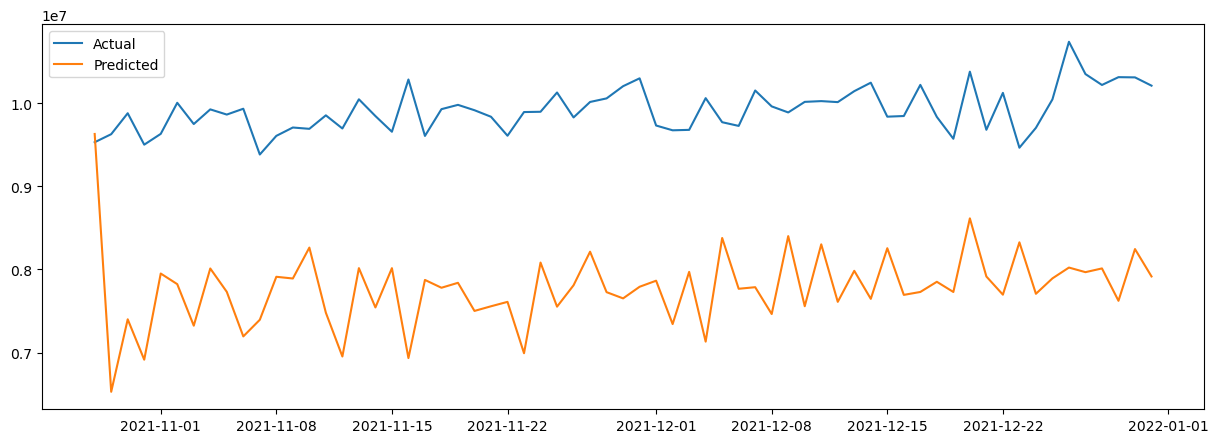

In [133]:
# MAE, RMSE
def evaluate_forecasts(actual, forecasts):
    mae = np.mean(np.abs(actual - forecasts))
    rmse = np.mean((actual - forecasts)**2)**.5
    return mae, rmse

# Evaluate the forecasts
mae, rmse = evaluate_forecasts(test, final_forecasts)

# Print
print('The MAE and RMSE for the test set are {} and {} respectively.'.format(round(mae, 2), round(rmse, 2))

# Plot the actual and predicted values
plt.figure(figsize=(15, 5))
plt.plot(df.index[-test_length:], df['Receipt_Count'][-test_length:], label='Actual')
plt.title('Actual vs Predicted in Test Set - Last 65 Days')
plt.plot(df.index[-test_length:], final_forecasts, label='Predicted')
plt.legend()
plt.show();

# Predicting 2022

## Arima Predictions

In [135]:
steps_ahead = 365  # Forecasting 365 days ahead

In [136]:
# Predict Arima
arima_forecasts = expanding_window_arima(df['Receipt_Count'], steps_ahead)

## STL Predictions

In [137]:
# Predict STL
stl_forecasts = expanding_window_STL(df['Receipt_Count'], steps_ahead, p=1, d=1, q=1)

# Stack the forecasts

In [138]:
# Average the forecasts
final_forecasts = stack_forecasts(arima_forecasts, stl_forecasts)

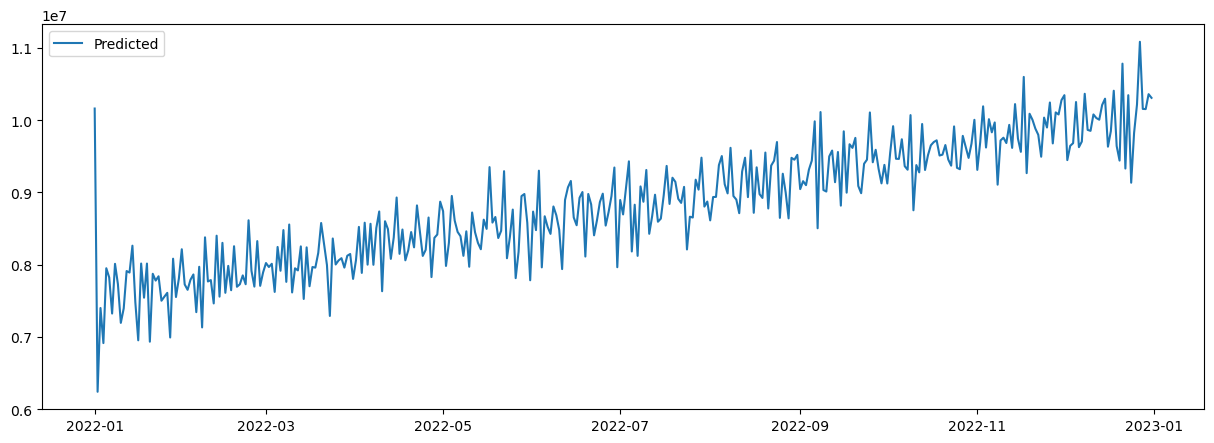

In [143]:
# Plot final_forecasts, xlabel is the year 2022
plt.figure(figsize=(15, 5))
plt.title('Predicted Receipt Count for 2022')
plt.plot(pd.date_range('2022-01-01', periods=steps_ahead, freq='D'), final_forecasts, label='Predicted')
plt.legend()
plt.show();

In [146]:
# Add a date index to the forecasts
final_forecasts = pd.Series(final_forecasts, index=pd.date_range('2022-01-01', periods=steps_ahead, freq='D'))

In [148]:
# Save the final_forecasts to a csv file
final_forecasts.to_csv('final_forecasts.csv')